In [1]:
import pandas as pd 
import numpy as np
import openpyxl
import matplotlib.pyplot as plt

In [2]:
df=pd.read_excel('/Users/bsharishkumar/Documents/algo_dashboard 2/Backtesting Report.xlsx')

In [3]:
df.columns

Index(['Trade #', 'Type', 'Date/Time', 'Signal', 'Price INR',
       'Position size (qty)', 'Position size (value)', 'Net P&L INR',
       'Net P&L %', 'Run-up INR', 'Run-up %', 'Drawdown INR', 'Drawdown %',
       'Cumulative P&L INR', 'Cumulative P&L %'],
      dtype='object')

In [4]:
max(df['Run-up INR'])

154871.97

Max Drawdown %: -78.56634016028494
Max Drawdown INR: -882.3
Peak Date: 2022-08-29 19:51:00
Bottom Date: 2025-08-25 13:24:00
Peak Price: 1123.0
Bottom Price: 240.7


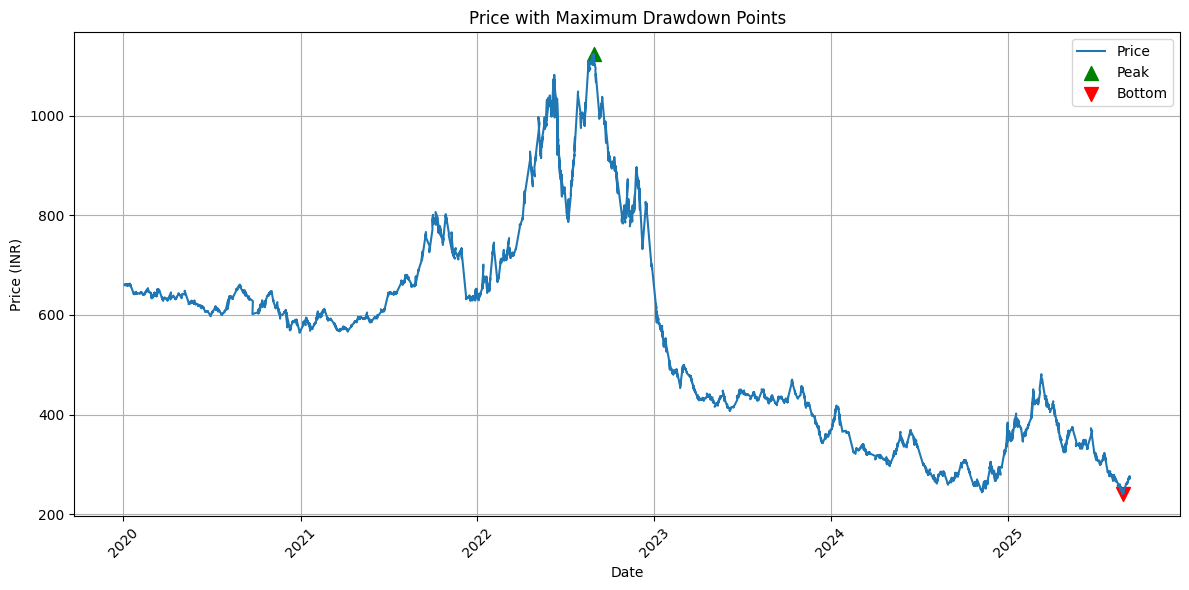

In [5]:
def calculate_max_drawdown(df):
    # Calculate running maximum
    running_max = df['Price INR'].expanding().max()
    
    # Calculate drawdown
    drawdown = (df['Price INR'] - running_max) / running_max
    
    # Find maximum drawdown and its corresponding dates
    max_drawdown = drawdown.min()
    max_drawdown_idx = drawdown.idxmin()
    
    # Find the peak before the maximum drawdown
    peak_idx = df['Price INR'][:max_drawdown_idx].idxmax()
    
    # Calculate drawdown in INR
    drawdown_inr = df.loc[max_drawdown_idx, 'Price INR'] - df.loc[peak_idx, 'Price INR']
    
    return {
        'Max Drawdown %': max_drawdown * 100,
        'Max Drawdown INR': drawdown_inr,
        'Peak Date': df.loc[peak_idx, 'Date/Time'],
        'Bottom Date': df.loc[max_drawdown_idx, 'Date/Time'],
        'Peak Price': df.loc[peak_idx, 'Price INR'],
        'Bottom Price': df.loc[max_drawdown_idx, 'Price INR']
    }

# Calculate and display results
results = calculate_max_drawdown(df)
for key, value in results.items():
    print(f"{key}: {value}")



plt.figure(figsize=(12, 6))
plt.plot(df['Date/Time'], df['Price INR'], label='Price')
plt.scatter(results['Peak Date'], results['Peak Price'], color='green', marker='^', s=100, label='Peak')
plt.scatter(results['Bottom Date'], results['Bottom Price'], color='red', marker='v', s=100, label='Bottom')
plt.title('Price with Maximum Drawdown Points')
plt.xlabel('Date')
plt.ylabel('Price (INR)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Sortino Ratio: -0.2306
Annualized Excess Return: -0.0783
Annualized Downside Deviation: 0.3394


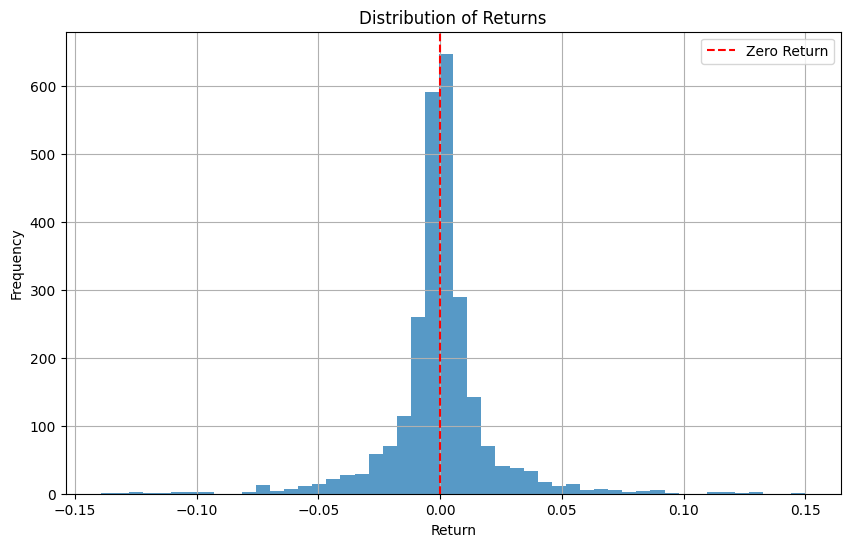

In [6]:
def calculate_sortino_ratio(df, risk_free_rate=0.05, periods_per_year=252):
    """
    Calculate Sortino Ratio from price data
    params:
        df: DataFrame with 'Price INR' column
        risk_free_rate: Annual risk-free rate (default 5%)
        periods_per_year: Number of trading periods in a year (252 for daily data)
    """
    # Calculate returns
    df['Returns'] = df['Price INR'].pct_change()
    
    # Calculate excess returns over risk-free rate
    excess_returns = df['Returns'] - (risk_free_rate / periods_per_year)
    
    # Calculate average excess return
    avg_excess_return = excess_returns.mean()
    
    # Calculate downside deviation (only negative returns)
    negative_returns = excess_returns[excess_returns < 0]
    downside_deviation = np.sqrt(np.mean(negative_returns**2)) * np.sqrt(periods_per_year)
    
    # Calculate Sortino Ratio
    sortino_ratio = (avg_excess_return * periods_per_year) / downside_deviation if downside_deviation != 0 else 0
    
    return {
        'Sortino Ratio': sortino_ratio,
        'Annualized Excess Return': avg_excess_return * periods_per_year,
        'Annualized Downside Deviation': downside_deviation
    }

# Calculate and display results
sortino_results = calculate_sortino_ratio(df)
for key, value in sortino_results.items():
    print(f"{key}: {value:.4f}")

# Visualize returns distribution
plt.figure(figsize=(10, 6))
plt.hist(df['Returns'].dropna(), bins=50, alpha=0.75)
plt.axvline(x=0, color='r', linestyle='--', label='Zero Return')
plt.title('Distribution of Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

Sharpe Ratio: -0.2294
Annualized Excess Return: -0.0783
Annualized Volatility: 0.3411


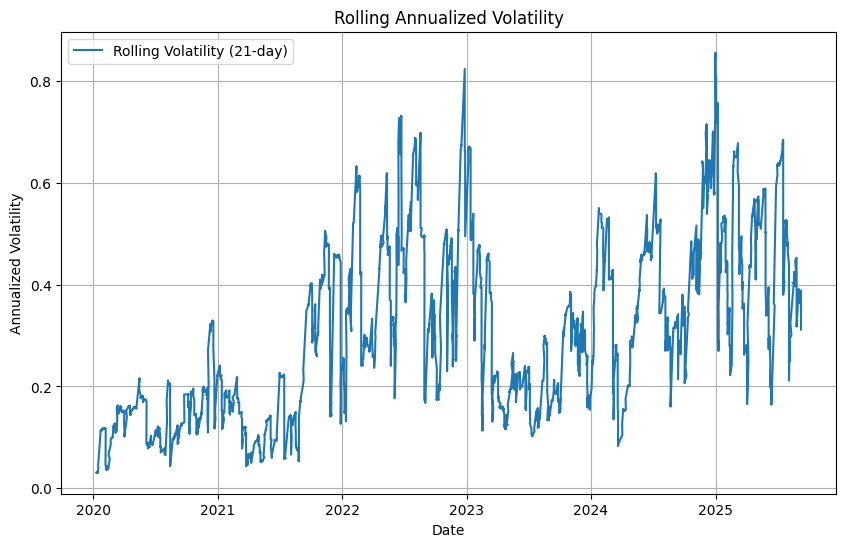

In [7]:
def calculate_sharpe_ratio(df, risk_free_rate=0.05, periods_per_year=252):
    """
    Calculate Sharpe Ratio from price data
    params:
        df: DataFrame with 'Price INR' column
        risk_free_rate: Annual risk-free rate (default 5%)
        periods_per_year: Number of trading periods in a year (252 for daily data)
    """
    # Calculate returns
    df['Returns'] = df['Price INR'].pct_change()
    
    # Calculate excess returns over risk-free rate
    excess_returns = df['Returns'] - (risk_free_rate / periods_per_year)
    
    # Calculate average excess return (annualized)
    avg_excess_return = excess_returns.mean() * periods_per_year
    
    # Calculate standard deviation of returns (annualized)
    std_dev = df['Returns'].std() * np.sqrt(periods_per_year)
    
    # Calculate Sharpe Ratio
    sharpe_ratio = avg_excess_return / std_dev if std_dev != 0 else 0
    
    return {
        'Sharpe Ratio': sharpe_ratio,
        'Annualized Excess Return': avg_excess_return,
        'Annualized Volatility': std_dev
    }

# Calculate and display results
sharpe_results = calculate_sharpe_ratio(df)
for key, value in sharpe_results.items():
    print(f"{key}: {value:.4f}")

# Visualize returns and volatility
plt.figure(figsize=(10, 6))
plt.plot(df['Date/Time'], df['Returns'].rolling(window=21).std() * np.sqrt(252), 
         label='Rolling Volatility (21-day)')
plt.title('Rolling Annualized Volatility')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
def calculate_cagr_rar(df):
    """
    Calculate CAGR and Risk-Adjusted Return
    params:
        df: DataFrame with 'Price INR' and 'Date/Time' columns
    """
    # Calculate CAGR
    first_price = df['Price INR'].iloc[0]
    last_price = df['Price INR'].iloc[-1]
    n_years = (df['Date/Time'].iloc[-1] - df['Date/Time'].iloc[0]).days / 365
    
    cagr = (last_price/first_price)**(1/n_years) - 1
    
    # Calculate Max Drawdown
    rolling_max = df['Price INR'].expanding().max()
    drawdown = ((df['Price INR'] - rolling_max) / rolling_max)
    max_drawdown = abs(drawdown.min())
    
    # Calculate RAR
    rar = cagr / max_drawdown if max_drawdown != 0 else 0
    
    return {
        'CAGR': cagr * 100,  # Convert to percentage
        'Max Drawdown': max_drawdown * 100,  # Convert to percentage
        'Risk-Adjusted Return': rar
    }

# Calculate metrics
results = calculate_cagr_rar(df)
for key, value in results.items():
    print(f"{key}: {value:.2f}%")

CAGR: -14.44%
Max Drawdown: 78.57%
Risk-Adjusted Return: -0.18%
